(c) Juan Gomez 2019. Thanks to Universidad EAFIT for support. This material is part of the course Introduction to Finite Element Analysis

# Creating a finite element discretization using gmsh and meshio

## Introduction

This Notebook describes basic steps in the creation of a two-dimensional finite element model using the mesh generation software gmsh. It also discusses the conversion of the resulting mesh into text files as requiered in many open source finite element code. In this case we will follow the format from SolidsPy.

 **After completing this notebook you should be able to:**

* Create finite element discretizations of simple two-dimensional computational domains using gmsh.

* Convert the mesh into text files using Python functions built on meshio.


## The model

The model is a simple rectangular domain fabricated of two different materials as indicated in the figure. The plate is loaded on the top surface by a uniform load of intensity $W$ units of force per unit of length. Recall that the plane strain assumption implies an infinite extension in the direction perpendicular to the plane of the model. The displacement boundary conditions correspond to roller supports along the lateral vertical surfaces and the bottom horizontal surface. In this tutorial we will focus only on the creation of the model without consideration of the stress analysis yet.


<center><img src="img/the_model.png" alt="mesh" style="width:400px"></center>

## The gmsh model

The definition of a model in gmsh involves 2 basic steps as follows:

* Geometry definition (file of extension .geo)

* Mesh definition: discretizastion of the geometry  into finite elements(file of extension .msh)

In gmsh a geometry is created through the definition and combination of hierarchical objects such as:

* Points (defined by its space coordinates in a reference system)

* Lines (defined by the ordered union of several points)

* Plane surfaces (also called  “line loops”) defined by the union of several lines forming a closed figure.

The figure shows the points numbered from $1$ through $6$, the lines numbered from $1$ through $7$ (note that each line is defined by an initial and a final point) and the plane surfaces or line loops defined by a group of nodes. The ordering of the group of nodes defines the direction of the loop. This direction will affect the node ordering in the finite elements assigned to the surface. Note that the in the definition of the loop $10$ line $7$ appears with a minus sign. This is to indicate that this line is being traversed in the negative direction.

**With the help of the instructor use gmsh to define the required points, lines and plane surfaces and to produce a finite element mesh.**

<center><img src="img/the_geometry.png" alt="mesh" style="width:400px"></center>

The geometric model is stored in a text file like the one shown below. The model has been parametrized in terms of the length $L$, height $H$ and characteristic finite element side $0.1$.

<center><img src="img/the_file.png" alt="mesh" style="width:400px"></center>

The geometric model and resulting mesh is shown in the figure.

<center><img src="img/the_mesh.png" alt="mesh" style="width:600px"></center>

## Using meshio to convert the mesh file into text files.

**meshio** is a Python package with a series of functions to conduct input/output operations upon many mesh formats including those of gmsh. We have used some of those functions to create subroutines or pseudo-commands to facilitate the conversion of the gmsh mesh file into SolidsPy required format. In this tutorial we will describe only the use of the subroutines necessary to write the nodes and elements files. The complete work flow is described in the figure.


<center><img src="img/the_pipe.png" alt="mesh" style="width:600px"></center>


The **mesh** or set of **finite elements** is defined by 2 basic geometric entities namely, the **nodal points** and the **elements**.The relavant data for a nodal point is defined by a nodal identifier (usually an integer) and by its corresponding space coordinates. Similarly an element is defined by and ordered arrangement of nodal points, called the element **connectivities**. The order of the nodal points defining an element must be consistent with the pre-defined order of the shape functions in the canonical element. In summary a mesh is defined by the identifiers and spatial coordinates of all the nodal points and by the connectivities of all the elements covering the computational domain. Some of the elements avialble in SolidsPy are shown below.


<center><img src="img/the_library.png" alt="mesh" style="width:600px"></center>

The preprocessor module in SolidsPy contains a set of subroutines that can directly interpret the mesh and write the required text files. In the following block of code we show these nodal writing and element writing subroutines.

We include the subroutines for the purpose of explanation- However they can be used directly after importing the preprocesor module from SolidsPy.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, CubicTriInterpolator
import meshio
#import solidspy.preprocesor as msh

In [2]:
def node_writer(points , point_data):
    """Write nodal data as required by SolidsPy

    Parameters
    ----------
    points : dictionary
        Nodal points
    point_data : dictionary
        Physical data associatted to the nodes.

    Returns
    -------
    nodes_array : ndarray (int)
        Array with the nodal data according to SolidsPy.

    """
    nodes_array = np.zeros([points.shape[0], 5])
    nodes_array[:, 0] = range(points.shape[0])
    nodes_array[:, 1:3] = points[:, :2]
    return nodes_array

In [3]:
def ele_writer(cells, cell_data, ele_tag, phy_sur,  ele_type, mat_tag, nini):
    """
    Extracts a subset of elements from a complete mesh according to the
    physical surface  phy_sur and writes down the proper fields into an
    elements array.

    Parameters
    ----------
        cell : dictionary
            Dictionary created by meshio with cells information.
        cell_data: dictionary
            Dictionary created by meshio with cells data information.
        ele_tag : string
            Element type according to meshio convention,
            e.g., quad9 or line3.
        phy_sur : int
            Physical surface for the subset.
        ele_type: int
            Element type.
        mat_tag : int
            Material profile for the subset.
        ndof : int
            Number of degrees of freedom for the elements.
        nnode : int
            Number of nodes for the element.
        nini : int
            Element id for the first element in the set.

    Returns
    -------
        nf : int
            Element id for the last element in the set
        els_array : int
            Elemental data.

    """
    eles = cells[ele_tag]
    dict_nnode = {'triangle': 3,
                  'triangle6': 6,
                  'quad': 4}
    nnode = dict_nnode[ele_tag]
    phy_surface = cell_data[ele_tag]['gmsh:physical']
    ele_id = [cont for cont, _ in enumerate(phy_surface[:])
              if phy_surface[cont] == phy_sur]
    els_array = np.zeros([len(ele_id) , 3 + nnode], dtype=int)
    els_array[: , 0] = range(nini , len(ele_id) + nini )
    els_array[: , 1] = ele_type
    els_array[: , 2] = mat_tag
    els_array[: , 3::] = eles[ele_id, :]
    nf = nini + len(ele_id)
    return nf , els_array

The text files generation script follows next. In the first block of code we read the gmsh file, in this case inter_template.msh.

In [4]:
mesh = meshio.read("files/inter_template.msh")
points = mesh.points
cells  = mesh.cells
point_data = mesh.point_data
cell_data  = mesh.cell_data
field_data = mesh.field_data

We now form the nodes array and leave it ready to be written in the text file.

In [8]:
nodes_array    = node_writer(points, point_data)

The next block forms arrays storing the elemental data. In the first line we form the array **els1_array()** storing the elements along the first physical surface with identifier $100$. The element counter will start at $0$ and will end in **nf**.

In [9]:
nf, els1_array = ele_writer(cells, cell_data, "triangle", 100, 3, 0, 0)

The next line will create the array **els2_array()** storing the elements along the second physical surface with identifier $200$. The element counter will start at **nini = nf** where **nf** is the last element from the previous surface

In [10]:
nini = nf
nf, els2_array = ele_writer(cells, cell_data, "triangle", 200, 3, 1, nini)

In the final line both elements arrays are collapsed into a single one using the numpy method append.

In [11]:
els_array      = np.append(els1_array, els2_array, axis=0)

As a final step we write the arrays into the corresponding text files.

In [12]:
np.savetxt("files/Peles.txt", els_array, fmt="%d")
np.savetxt("files/Pnodes.txt", nodes_array, fmt=("%d", "%.4f", "%.4f", "%d", "%d"))

#### Visualize the mesh

In [13]:
def viewmesh(nodes , elements , view = False):
    #
    """Generates and displays a matplotlib.tri.Triangulation object created from a
       user defined finite element mesh given by nodes and elements.

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==2:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==3:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    if view:
        plt.figure()
        plt.gca().set_aspect('equal')
        plt.triplot(tri, lw=0.5, color='red')

    return tri

<IPython.core.display.Javascript object>


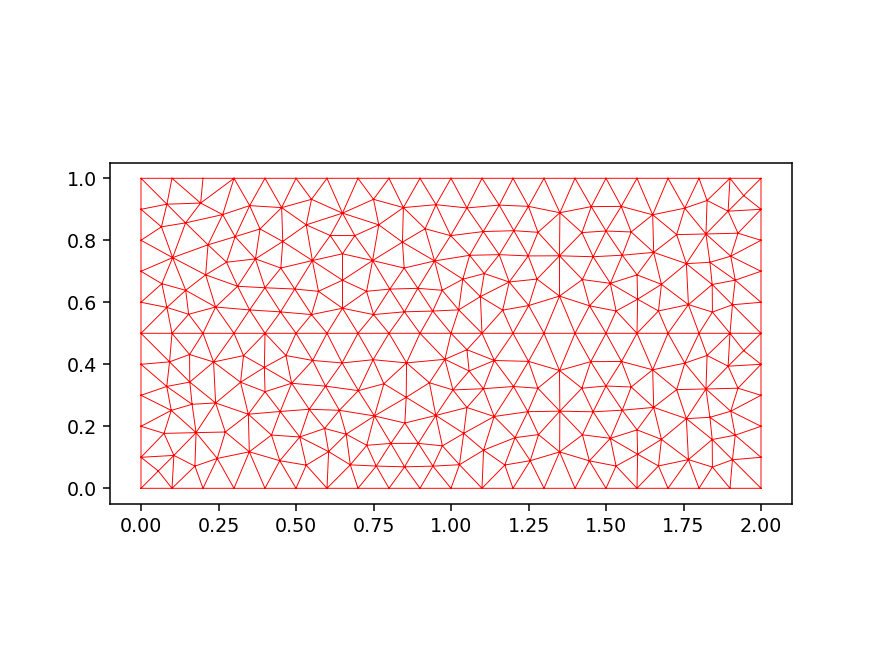

In [14]:
nodes        = np.loadtxt('files/'+'Pnodes.txt')
elements     = np.loadtxt('files/'+'Peles.txt')
trii = viewmesh(nodes , elements , True)

### Glossary of terms.

**Finite element:** Interpolation space of predefined geometry and its associated interpolation functions.

**Element connectivities:** Ordered list of integers identifying nodal points conforming a given finite element.

**Finite element mesh:** A finite number of non-overlapping finite elements covering a complete computational domain.

**SolidsPy:** Finite element solver for the stress analysis of two-dimensional arbitrary domains written in Python.

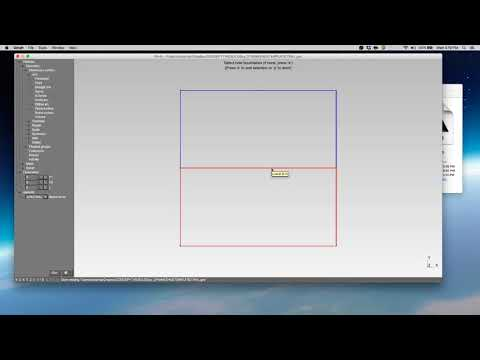

In [12]:
from IPython.display import YouTubeVideo
YouTubeVideo('ibeIKaSYG2U')

### References

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

* Timoshenko, S.P., and Goodier, J.N. (1976). Theory of Elasticity. International Student Edition. McGraw-Hill International.

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()